Alex 13. 3. 21

### Cross validation in finance

Cross validation is the gold standard technique used to 

- estimate the exptected generalization error (model assessment)
- do hyperparameter tuning (model selection)
- do both model selection and model assessment via nested CV


**The main reason why CV fails in finance is because observations cannot be assumed to be drawn from an IID process, which creates leakage. Concretely, information from the testing set leaks into the training set, which inflates the testing accuracy**

(another reason is because the testing set is used multiple times which leads to a multiple testing and selection bias but this 
is not the focus of this notebook)

#### Leakage

Leakage takes place when the training set contains information that also appears in the testing set. Consider a serially correlated feature $X$ that is associated with labels $Y$ that are formed on **overlapping** data (i.e. $Y_t$ and $Y_{t+1}$ depend on common returns, i.e. common price data):

- because of serial correlation $X_t \approx X_{t+1}$
- because labels are derived from overlapping data points $Y_t \approx Y_{t+1}$
- thus $(Y_t, X_t) \approx (Y_{t+1}, X_{t+1})$. So if a classifier is trained on $(Y_t, X_t)$ it can predict $Y_{t+1}$ based on $X_{t+1}$ pretty well because they are built on same information, i.e. they are dependent. 

Thus by placing $t$ in training set and $t+1$ in test set, **information leaks from the test set into the training set**. 

Consequence: **When a classifier is trained on $(Y_t, X_t)$ and then is asked to predict $\text{E}[Y_{t+1} |X_{t+1}]$ the classifier is more likely to achieve $Y_{t+1} = \text{E}[Y_{t+1} |X_{t+1}]$ even if $X$ is an irrelevant feature. If X is a predictive feature, leakage will enhance the performance of an already valuable strategy.** So in any case, leakage inflates the expected performance of the model. 


Note: **For leakage to occur it must hold $(X_{t}, Y_{t})$ $\approx$ $(X_{t+1}, Y_{t+1})$, and it's not enough that $X_t \approx X_{t+1} $ or even $Y_{t} \approx Y_{t+1}$.**


#### Purged CV 


Purged CV solves the leakage problem by removing training set observations whose labels overlap with test set labels: if a test set label $y_j$ depends on information $\Phi_j$, training set labels that depend on $\Phi_j$ should be removed. 



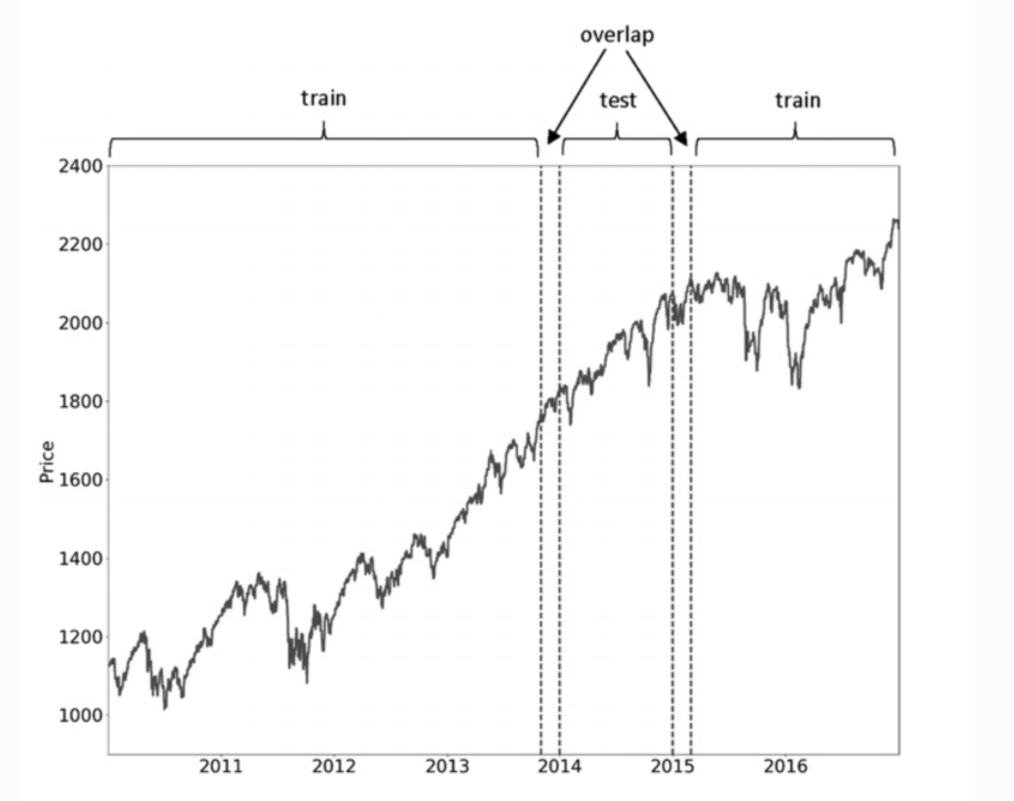

In [4]:
from IPython.display import Image
Image(filename='CV.png',width=400) 

Additionally, one can do an embargo, which removes a number of training observations from the *after* every test set. This prevents further leakage where purging is not enough. 

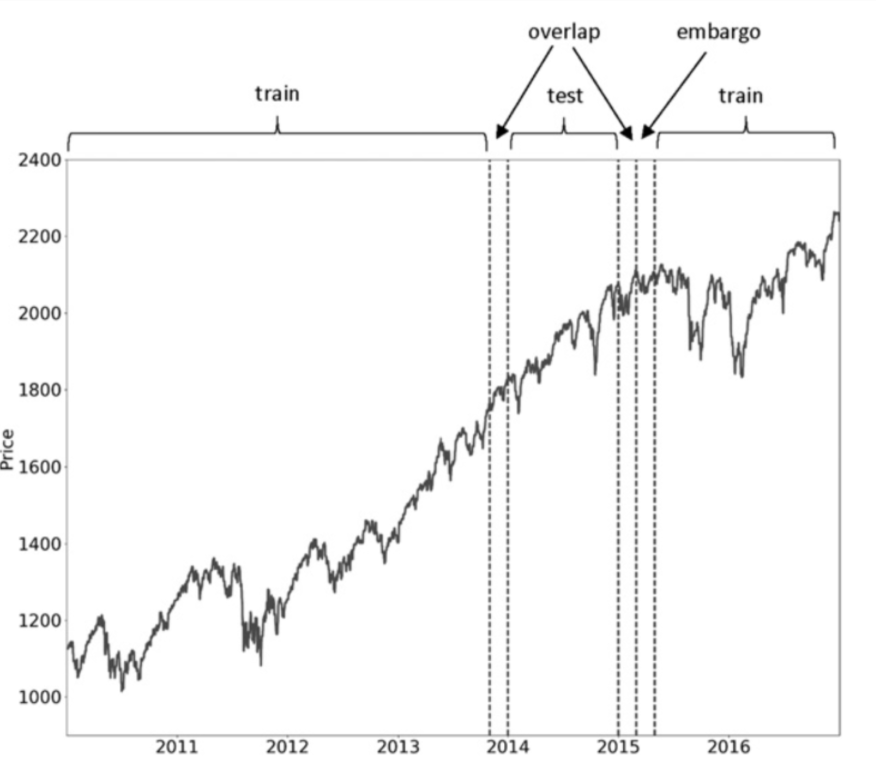

In [5]:
from IPython.display import Image
Image(filename='CV2.png', width=400) 

#### AFML excercises Ch. 7


##### Why is shuffling a dataset before conducting k-fold CV generally a bad idea in finance?

Usually in finance we are working with time series structured data, so by shuffling before conducting a k-fold we are sure to have data in our training set that shares information with the data in our testing set. This can easily lead to leakage


##### Why does shuffling defeat the purpose of k-fold in financial datasets?


The goal of any cross-validation technique is to estimate the generalization error of a model on an test set which is **independent** of the training set. 

By shuffling first, we are making sure that the data set will not be independent of the train data because of leakage between the test and train set after the shuffling.

#### Take a pair of matrices (X,y) representing observed features and labels. 


In [34]:
import mlfinlab as ml
import pandas as pd
import numpy as np

from mlfinlab.cross_validation import ml_cross_val_score
from mlfinlab.cross_validation import PurgedKFold
from mlfinlab.util.multiprocess import mp_pandas_obj
from mlfinlab.sampling import concurrent

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

FNM = 'results_3-5.csv'
rf_cfg = {
    "criterion": 'entropy',
    "max_depth": 5,
    "n_estimators": 100,
    "class_weight": 'balanced_subsample'
}


X = pd.read_csv(FNM, index_col=0)

y = X.pop('bin')
weights= X.pop('weights')
samples_info_sets = X.pop('t1')

idx_shuffle = np.random.permutation(X.index)

In [16]:
display(X.head())
display(y.head())

,rsi,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,sma
2015-01-06 16:23:23.744,24.0,1.0,-0.001247,-0.001246,-0.001620,-0.001868,-0.003854,-0.004349,0.001183,-0.065977,-0.043867,-0.066452,0.117382,-0.012400,-0.000374,-0.000249,-0.001991,-0.000497,-0.000869,-1.0
2015-01-06 16:35:18.127,20.0,1.0,-0.000999,-0.000999,-0.001248,-0.002493,-0.002866,-0.003114,0.001158,-0.038315,-0.030594,-0.060636,0.170363,-0.046009,-0.000250,-0.001247,-0.000374,-0.000249,-0.001991,-1.0
2015-01-06 16:40:02.336,18.0,1.0,-0.000500,-0.000500,-0.001498,-0.001747,-0.002991,-0.003364,0.001159,-0.033713,-0.030061,-0.051160,0.170552,-0.044667,-0.000999,-0.000250,-0.001247,-0.000374,-0.000249,-1.0
2015-01-06 16:44:48.791,15.0,1.0,-0.001251,-0.001250,-0.001749,-0.002746,-0.002995,-0.004238,0.001169,-0.027737,-0.008073,-0.051415,0.187493,-0.041416,-0.000500,-0.000999,-0.000250,-0.001247,-0.000374,-1.0
2015-01-06 17:09:12.134,12.0,1.0,-0.002131,-0.002129,-0.002129,-0.001253,-0.002503,-0.003750,0.001180,-0.003244,-0.065480,-0.000985,0.208039,-0.032036,0.000000,0.000877,-0.001253,-0.001251,-0.000500,-1.0


2015-01-06 16:23:23.744    0
2015-01-06 16:35:18.127    1
2015-01-06 16:40:02.336    1
2015-01-06 16:44:48.791    1
2015-01-06 17:09:12.134    1
Name: bin, dtype: int64

a) Derive the performance from a 10-fold CV of a RF classifier on (X,y) without shuffling

In [31]:
clf = RandomForestClassifier(**rf_cfg)

cv_spec = KFold(n_splits=10, shuffle=False)
scores = cross_val_score(estimator=clf,
                        X=X,
                        y=y,
                        cv=cv_spec)
scores.mean()



0.5096065766294775

b) Now do the same with shuffling

In [32]:
clf = RandomForestClassifier(**rf_cfg)

cv_spec = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(estimator=clf,
                        X=X,
                        y=y,
                        cv=cv_spec)
scores.mean()


0.6133235466823252

**Important: The reason why the test MSE of CV with shuffling is higher is because of leakage!**

In a time series context, we are using information from the past to predict the future. By shuffling, we destroy the temporal structure. The train data set will have information relevant for the test data set, it will be able to peak into the future!

#### Now do purged CV

In [40]:
cv_gen = PurgedKFold(n_splits=10, samples_info_sets = samples_info_sets, pct_embargo=0.01)
scores = cross_val_score(estimator=clf,
                        X=X,
                        y=y,
                        cv=cv_gen)
scores.mean()

0.5011215502055196

Performance is lower because we prevent leakage, i.e. we remove training samples that share common information with test samples. Thus no information from the test set leaks into the training set. 